# Connecting to SQL Database using `pyodbc` Library in Python


This notebook is a step-by-step guide to help you learn how to use Python functions and libraries to connect to an SQL database using the `pyodbc` library. Each section of the notebook includes an explanation of the code, which you can run in order to understand the workflow step by step.






## Preparing the SQL Database

Before using Python, we need to decide which SQL database to connect to. For this exercise, we will use the A Cloud Guru (ACG) sandbox to create an SQL database. Once the database is set up, we will obtain the necessary credentials to connect to it using Python. 

A detailed guide on how to create the SQL database in the ACG sandbox is available in a GitHub repository called [DE-sql-learning-environment-Azure](https://github.com/Corndel/DE-sql-learning-environment-Azure). 

Following the instructions provided in the repository from step **1 Create the ACG Sandbox for SQL learning** to step **4 Create tables in Azure SQL database and insert data**, by the completion of which you will have created an SQL database called **sakila**. We will need the **connection strings** for this database in order to be able to connect to it using Python library `pyodbc`. 

## Steps to Acquire the Connection Strings
- Visit the SQL databases in the Azure portal (you can search for this service using the search box at the top and type SQL).
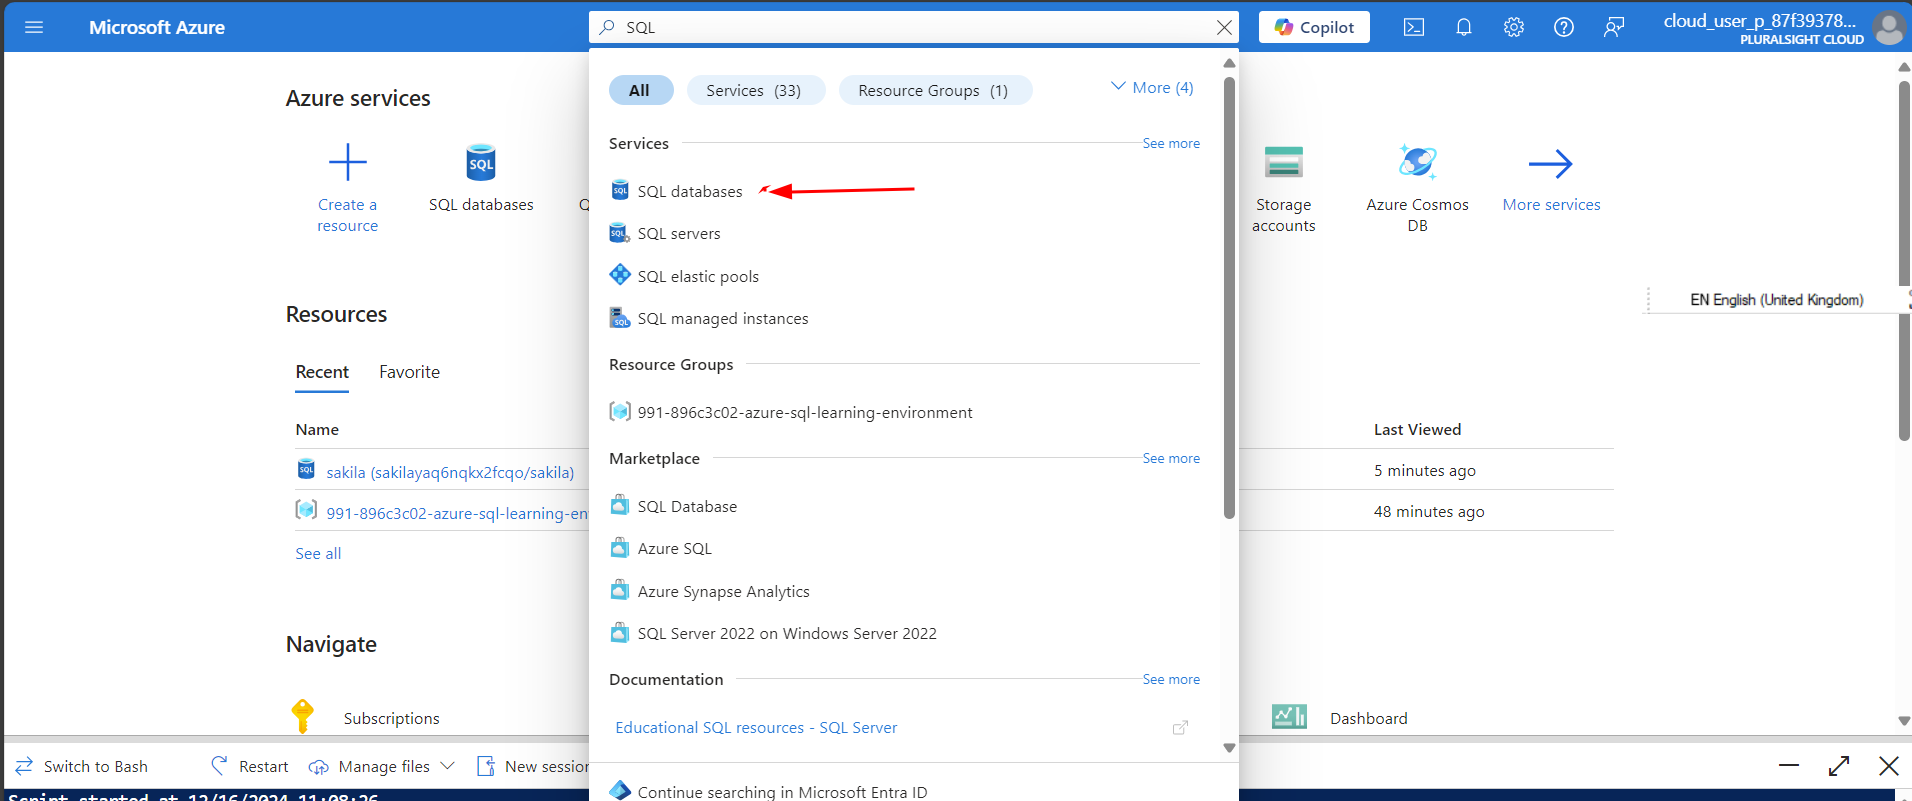

- In the list of databases that appears, click on the single database shown as **sakila (sakilayaq6nqkx2fcqo/sakila)**.
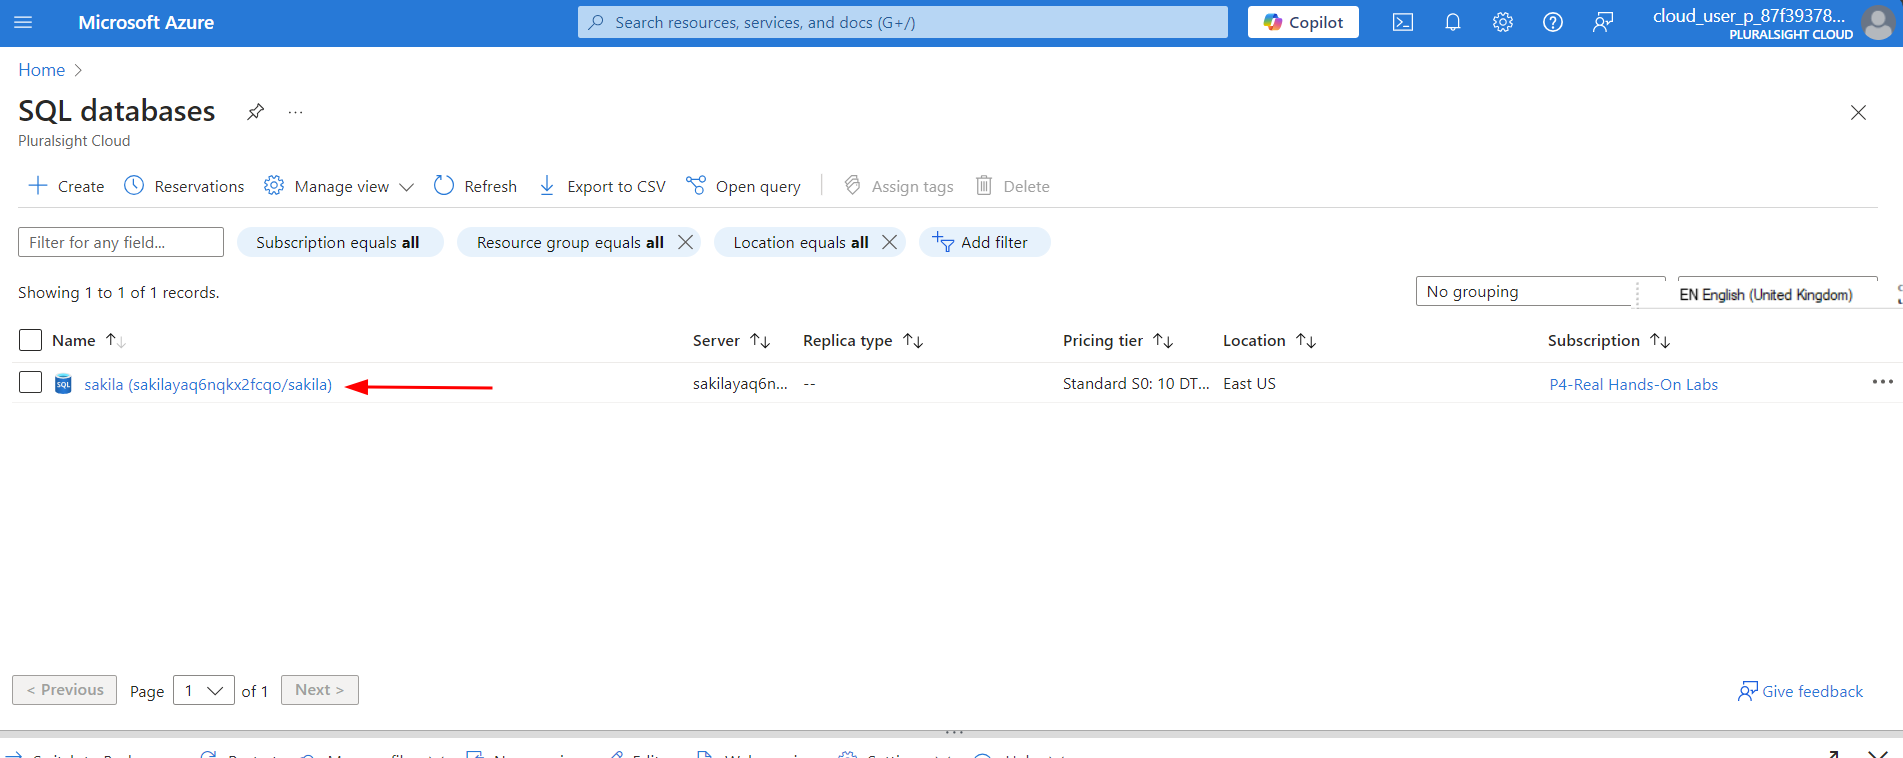

- Click on **Settings** and then on **Connection Strings** in the drop down menu as shown.
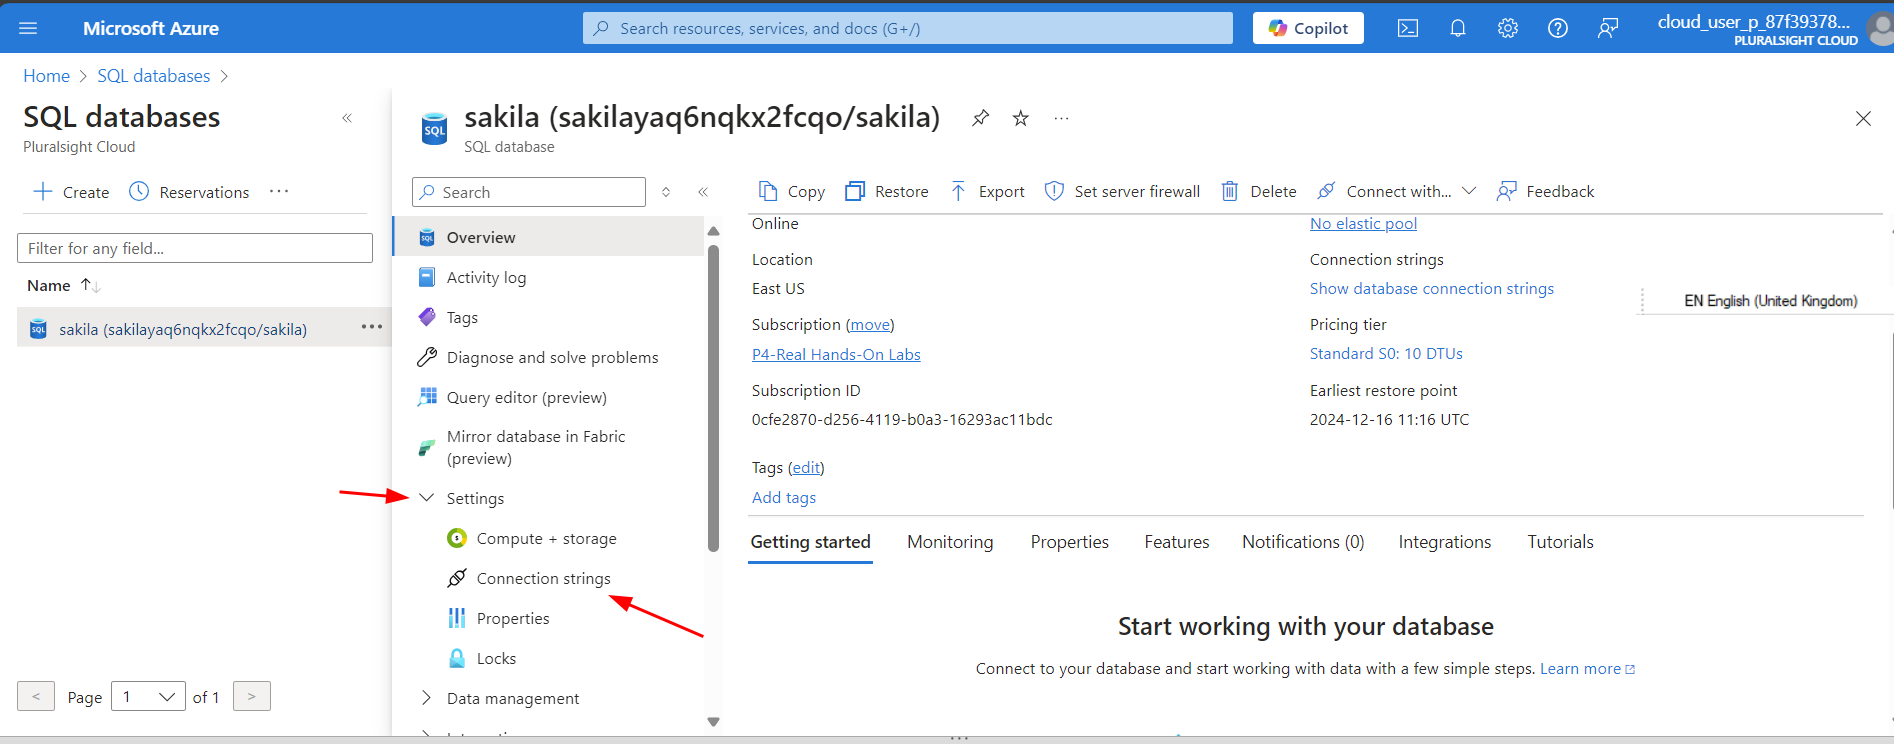

- Go to the `ODBC`tab to see the connection string as shown.
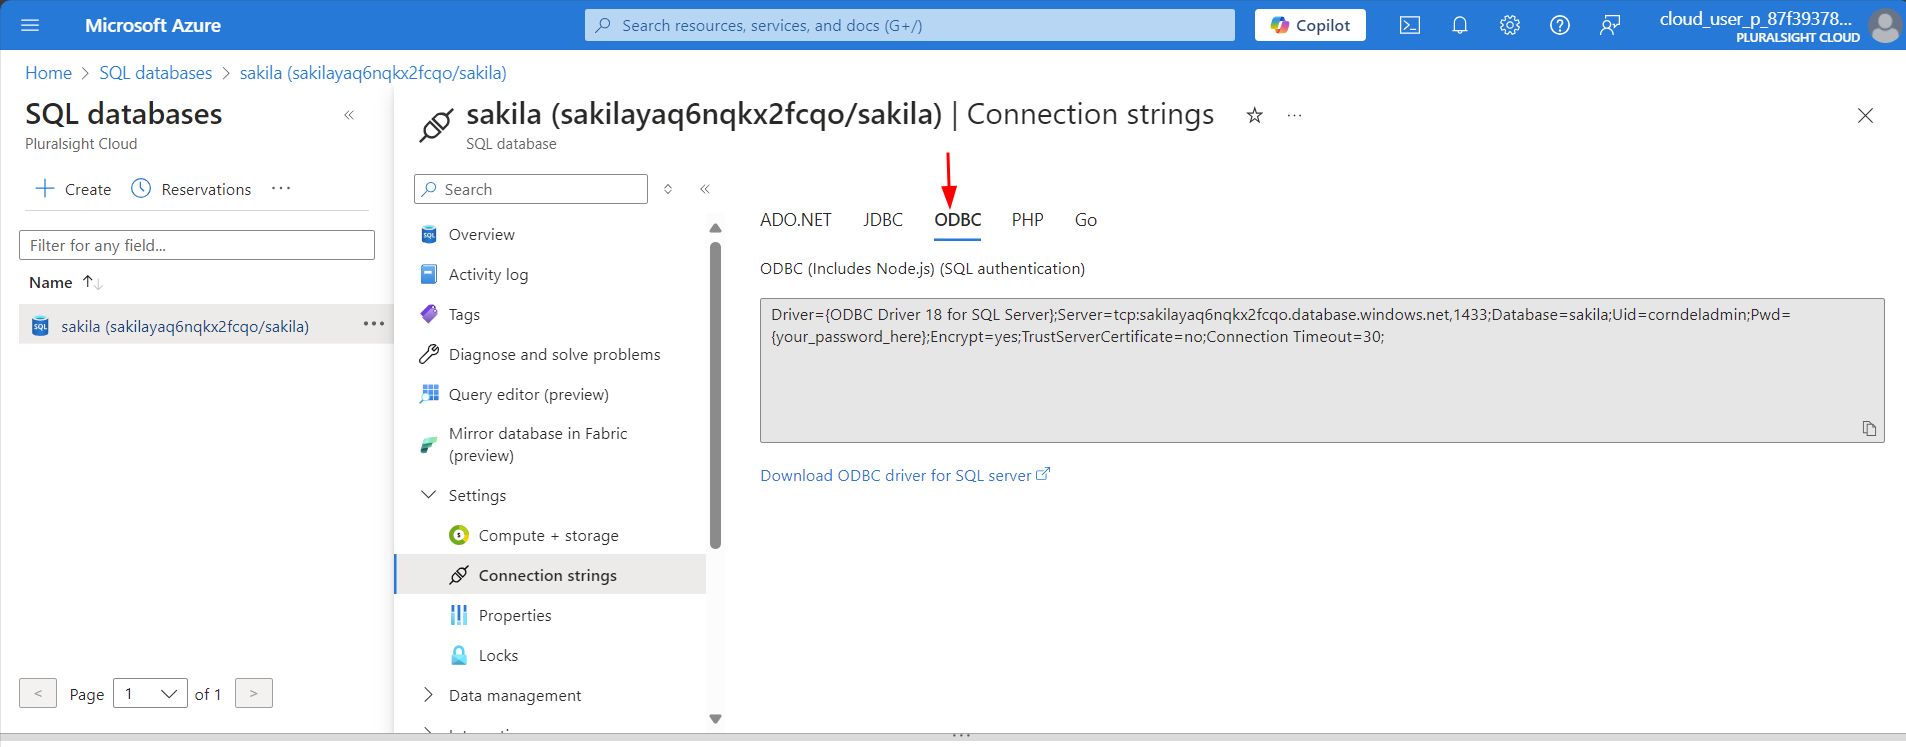

- You will need to copy the underlined **Connection Strings** and store it somewhere safely to be used later in the Python script.
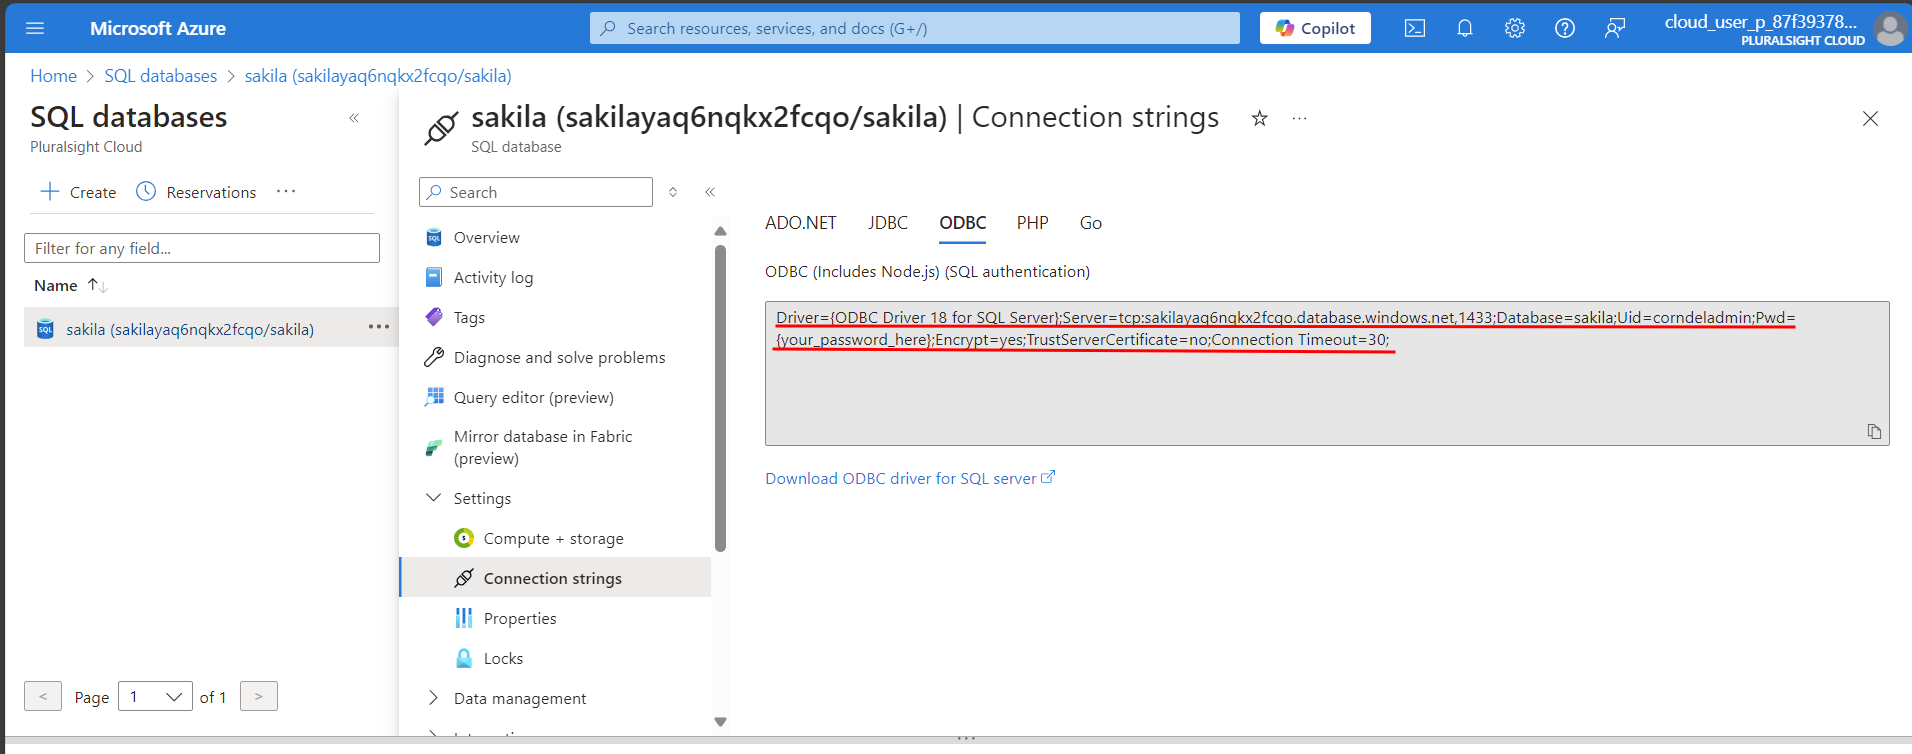

- You will also need to replace *{your_password_here}* within the connection strings with the actual password of the database which is **Password01**.

![test image](images/test.png)



## Connecting to the **Sakila** Database and Creating an ETL Pipeline

This guide will walk you through the steps (using the `pyodbc` library) to connect to the SQL database we have just created. You will learn how to extract data from the database, manage tables within it, and write the processed data back into the database. Follow each step carefully to gain a clear understanding of how to build an ETL pipeline when you are using Python to work with SQL databases on virtual machines or on remote platforms online.


### The Python Libraries

#### 1. `pyodbc`
It is a Python library for connecting to SQL databases using ODBC drivers. It allows communication between Python and SQL databases, making it essential for running SQL queries and managing database connections.

---

#### 2. `pandas`
This is a Python library for data manipulation and analysis. It provides powerful tools to handle tabular data, such as reading, writing, and processing datasets extracted from the database.

---

#### 3. `os`
This is a standard Python library for interacting with the operating system. It enables tasks like file and directory manipulation, crucial for managing input/output files during the ETL process.

---

#### 4. `shutil`
It is a standard Python library for high-level file operations. It helps in efficiently clearing or organising folders by removing directories and their contents.

---

#### 5. `logging`
This library is used for tracking events during code execution. It provides detailed logs for debugging and monitoring the ETL pipeline, ensuring transparency and easier troubleshooting.

#### 5. `getpass`
The `getpass` library in Python securely prompts the user for sensitive information, such as passwords, without displaying the input on the screen. It is ideal for creating secure, interactive command-line applications.

Let's run the following cell to import all of these libraries.


In [21]:
import pyodbc
import pandas as pd
import os
import shutil
import logging
import getpass

This code in the next cell uses the `logging` library to set up logging for the ETL pipeline to track events and errors. It writes logs to a file named `etl_pipeline.log` and displays them on the console. The log messages include the time, log level, and the message for clear and detailed tracking of the pipeline’s progress.


In [2]:
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("etl_pipeline.log"),
                        logging.StreamHandler()
                    ])

#### Function: `clear_folder`

This function removes all files and subdirectories within a specified folder. It iterates through each item in the folder, deleting files, symbolic links, and entire directories as needed. The process is logged for transparency, with messages indicating when the operation starts, completes, or encounters an error. This function is particularly useful for ensuring a clean workspace before running an ETL pipeline or similar processes. We will use this function to ensure that our target folder is cleared before the ETL output is written into it. Our target folder for this function is called `reports`, which will be used when we run the pipeline.


In [3]:
def clear_folder(folder_path):
    logging.info(f"Starting to clear the contents of folder: {folder_path}")
    try:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        logging.info(f"Contents of folder {folder_path} have been cleared.")
    except Exception as e:
        logging.error(f"Error while clearing folder {folder_path}: {e}")

#### Function: `manage_tables`
The `manage_tables` function is responsible for resetting the structure of specific database tables. It connects to the database using the provided connection string and executes SQL scripts to drop existing tables (`payment_summary_table` and `duration_summary_table`) and recreate them. The function reads the SQL commands from files located in the `queries` folder, ensuring the database is prepared for new data. It handles errors, such as database connection issues or missing SQL files, and logs the process for transparency and troubleshooting.


In [4]:
def manage_tables(connection_string):
    logging.info("Starting to manage tables in the database.")
    try:
        connection = pyodbc.connect(connection_string)
        cursor = connection.cursor()

        # Paths to the SQL files
        drop_payment_table_file = os.path.join('queries', 'drop_payment_summary_table.sql')
        drop_duration_table_file = os.path.join('queries', 'drop_duration_summary_table.sql')
        create_payment_table_file = os.path.join('queries', 'create_payment_summary_table.sql')
        create_duration_table_file = os.path.join('queries', 'create_duration_summary_table.sql')

        # Helper function to execute SQL files
        def execute_sql_file(file_path):
            with open(file_path, 'r') as file:
                sql = file.read()
                cursor.execute(sql)

        # Execute drop table SQL files
        execute_sql_file(drop_payment_table_file)
        execute_sql_file(drop_duration_table_file)
        connection.commit()

        # Execute create table SQL files
        execute_sql_file(create_payment_table_file)
        execute_sql_file(create_duration_table_file)
        connection.commit()

        logging.info("Tables payment_summary_table and duration_summary_table have been recreated in the database.")
    except pyodbc.Error as e:
        logging.error(f"Error managing tables: {e}")
    except FileNotFoundError as e:
        logging.error(f"SQL file not found: {e}")
    finally:
        if 'connection' in locals() and connection:
            connection.close()

#### Function: `calculate_payments`
The `calculate_payments` function reads an SQL query from a specified file, executes it on a database, and retrieves the results as a pandas DataFrame. The function connects to the database using a given connection string and processes the query to calculate a payments summary, including columns such as `Records`, `Minimum`, `Maximum`, `Total`, and `Average`. It logs progress and errors for transparency and closes the database connection after execution. The result is returned as a structured DataFrame for further analysis.


In [5]:
def calculate_payments(sql_file_path, connection_string):
    logging.info("Starting to calculate payments summary.")
    try:
        connection = pyodbc.connect(connection_string)
        cursor = connection.cursor()
        with open(sql_file_path, 'r') as file:
            sql_query = file.read()
        cursor.execute(sql_query)
        rows = cursor.fetchall()
        payments_summary = pd.DataFrame((tuple(t) for t in rows)) 
        payments_summary.columns = ['Records', 'Minimum', 'Maximum', 'Total', 'Average']
        logging.info("Payments summary successfully retrieved.")
    except pyodbc.Error as e:
        logging.error(f"Error executing payments query: {e}")
    finally:
        if 'connection' in locals() and connection:
            connection.close()
    return payments_summary

#### Function: `calculate_duration`

This function retrieves a summary of film durations from an SQL database by executing a query provided in an external SQL file. It connects to the database using the given connection string, reads the query from the specified file, and runs it. The results are then stored in a pandas DataFrame with columns: `Minimum`, `Maximum`, `Total`, and `Average`. Finally, it logs the process and ensures the database connection is closed.


In [6]:
def calculate_duration(sql_file_path, connection_string):
    logging.info("Starting to calculate duration summary.")
    try:
        connection = pyodbc.connect(connection_string)
        cursor = connection.cursor()
        with open(sql_file_path, 'r') as file:
            sql_query = file.read()
        cursor.execute(sql_query)
        rows = cursor.fetchall()
        duration_summary = pd.DataFrame((tuple(t) for t in rows)) 
        duration_summary.columns = ['Minimum', 'Maximum', 'Total', 'Average']
        logging.info("Duration summary successfully retrieved.")
    except pyodbc.Error as e:
        logging.error(f"Error executing duration query: {e}")
    finally:
        if 'connection' in locals() and connection:
            connection.close()
    return duration_summary

#### Function: `write_dataframe_to_db`

The `write_dataframe_to_db` function inserts the rows of a pandas DataFrame into a specified SQL database table. It connects to the database using the provided connection string, then iterates through each row of the DataFrame and executes an SQL `INSERT` statement to write the data. The function dynamically matches column names and values using placeholders to ensure compatibility. It also handles errors gracefully by logging issues and ensuring the database connection is properly closed after the operation.


In [7]:
def write_dataframe_to_db(dataframe, table_name, connection_string):
    logging.info(f"Starting to write DataFrame to table: {table_name}")
    try:
        connection = pyodbc.connect(connection_string)
        cursor = connection.cursor()
        # Insert rows into the database
        for index, row in dataframe.iterrows():
            placeholders = ', '.join(['?'] * len(row))
            columns = ', '.join(dataframe.columns)
            sql = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
            cursor.execute(sql, tuple(row))
        connection.commit()
        logging.info(f"Data successfully written to table: {table_name}.")
    except pyodbc.Error as e:
        logging.error(f"Error writing to database table {table_name}: {e}")
    finally:
        if 'connection' in locals() and connection:
            connection.close()

#### Function: `write_local_txt_output`

This function saves the contents of a pandas DataFrame as a tab-separated text file in a specified folder. It first ensures the folder exists (creating it if necessary), then writes the DataFrame to a file with the given name. The file does not include row indices, making it cleaner for sharing or further processing. If successful, the function logs the file’s location and returns its path. In case of an error, it logs the issue and returns `None`, ensuring clear feedback for troubleshooting.


In [8]:
def write_local_txt_output(dataframe, folder_path, file_name):
    logging.info(f"Starting to write DataFrame to text file: {file_name}")
    try:
        os.makedirs(folder_path, exist_ok=True)
        file_path = os.path.join(folder_path, file_name)
        dataframe.to_csv(file_path, sep='\t', index=False)
        logging.info(f"Processed data successfully written to {file_path}")
        return file_path
    except Exception as e:
        logging.error(f"An error occurred while writing to text file {file_name}: {e}")
        return None

#### Running the pipeline

This part of the code defines the entry point for running the ETL pipeline. Here, we provide the connection string, which we saved earlier from the ODBC tab for the SQL database **sakila** that we created on the ACG sandbox. This is required to establish a connection with the SQL database. Additionally, we declare the target folder for writing the output files locally, which is named `reports` in this case. The rest of the code orchestrates the execution of each function in the correct order: clearing the target folder, managing database tables, calculating summaries for payments and durations, writing the processed data back to the database, and finally saving the results as text files in the specified folder.


In [22]:
if __name__ == "__main__":
    server = input("Please enter the SQL Server address (hint: starts with tcp and ends with .net): ").strip()
    username = input("Please enter the your Username:").strip()
    password = getpass.getpass("Please enter the your Password: ").strip()
    connection_string =   str(
    f"Driver={{ODBC Driver 18 for SQL Server}};"
    f"Server={server},1433;"
    f"Database=sakila;"
    f"Uid={username};"
    f"Pwd={password};"
    f"Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"
)
    target_folder = "reports"

    clear_folder(target_folder)
    manage_tables(connection_string)
    payments_df = calculate_payments("queries/payments.sql", connection_string)
    duration_df = calculate_duration("queries/filmduration.sql", connection_string)

    write_dataframe_to_db(payments_df, "payment_summary_table", connection_string)
    write_dataframe_to_db(duration_df, "duration_summary_table", connection_string)

    write_local_txt_output(payments_df, "reports", "payment_summary.txt")
    write_local_txt_output(duration_df, "reports", "duration_summary.txt")

2024-12-16 16:15:19,006 - INFO - Starting to clear the contents of folder: reports
2024-12-16 16:15:19,016 - INFO - Contents of folder reports have been cleared.
2024-12-16 16:15:19,019 - INFO - Starting to manage tables in the database.
2024-12-16 16:15:22,202 - INFO - Tables payment_summary_table and duration_summary_table have been recreated in the database.
2024-12-16 16:15:22,205 - INFO - Starting to calculate payments summary.
2024-12-16 16:15:24,000 - INFO - Payments summary successfully retrieved.
2024-12-16 16:15:24,250 - INFO - Starting to calculate duration summary.
2024-12-16 16:15:26,061 - INFO - Duration summary successfully retrieved.
2024-12-16 16:15:26,312 - INFO - Starting to write DataFrame to table: payment_summary_table
2024-12-16 16:15:28,351 - INFO - Data successfully written to table: payment_summary_table.
2024-12-16 16:15:28,354 - INFO - Starting to write DataFrame to table: duration_summary_table
2024-12-16 16:15:30,411 - INFO - Data successfully written to t